In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install keras-tuner

In [ ]:
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cbook as cbook
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.losses import MeanAbsoluteError
import keras
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
path = r'/content/gdrive/MyDrive/bus' # use your path
all_files = glob.glob(path + "/*.csv")

In [ ]:
#Taking the last 3 session files as the TEST dataset
all_files.sort()
all_files_train = all_files[:-5]
all_files_test = all_files[-5:]

In [ ]:
# Train Dataset
li_train = []
for filename in all_files_train:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame_train = pd.concat(li_train, axis=0, ignore_index=True)
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.0,7.0,10.0,10.0,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.0,7.0,7.0,10.0,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.0,8.0,7.0,7.0,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.0,8.0,8.0,7.0,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.0,10.0,8.0,8.0,151,68,0,0,0,2393


In [ ]:
# Test Dataset
li_test = []
for filename in all_files_test:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_test.append(df)
frame_test = pd.concat(li_test, axis=0, ignore_index=True)
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,8,8,8,8,8,3657,5413,7795,7795,6777,...,6.0,6.0,6.0,7.0,162,100,143,143,128,4656
1,8,8,8,8,8,4719,3657,5413,7795,7795,...,4.0,6.0,6.0,6.0,155,162,100,143,143,5294
2,6,8,8,8,8,7280,4719,3657,5413,7795,...,4.0,4.0,6.0,6.0,144,155,162,100,143,6627
3,7,6,8,8,8,3813,7280,4719,3657,5413,...,3.0,4.0,4.0,6.0,70,144,155,162,100,9069
4,7,7,6,8,8,4742,3813,7280,4719,3657,...,3.0,3.0,4.0,4.0,86,70,144,155,162,10859


In [ ]:
frame_train.shape

(9138, 46)

# Dealing with Nan Values

## Train Dataframe

In [ ]:
frame_train.replace('-', np.NaN, inplace = True)
frame_train.isna().sum().sum()

86906

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame_train)
frame_train = pd.DataFrame(imputed_dataset,columns = frame_train.columns)
frame_train.isna().sum().sum()

0

In [ ]:
frame_train.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000,...,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000,8197.000000
mean,8.229001,8.090077,8.084747,8.071343,8.102723,9018.470416,9029.223008,9040.430767,9050.763816,9064.684397,...,5.136713,4.986677,4.943772,4.963642,165.247042,165.416372,165.582896,165.740027,165.940100,8995.436257
std,2.491529,2.491095,2.491217,2.492870,2.492022,10950.157021,10971.335775,10983.581112,10996.280548,11021.036435,...,6.830651,6.802626,6.796114,6.801465,179.329070,179.562678,179.719953,179.888185,180.146445,10409.724862
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-15.000000,-15.000000,-15.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.000000,7.000000,7.000000,7.000000,1610.000000,1621.000000,1621.000000,1621.000000,1621.000000,...,1.000000,1.000000,1.000000,1.000000,39.000000,39.000000,40.000000,40.000000,40.000000,1849.000000
50%,8.327186,7.996259,7.966751,7.927974,8.000000,4999.000000,5010.000000,5011.000000,5032.000000,5032.000000,...,6.485793,6.026931,5.903559,5.946580,104.000000,105.000000,105.000000,105.000000,105.000000,5253.000000
75%,9.000000,9.000000,9.000000,9.000000,9.000000,12391.000000,12391.000000,12414.000000,12436.000000,12458.000000,...,7.000000,7.000000,7.000000,7.000000,232.000000,232.000000,233.000000,233.000000,233.000000,12373.000000
max,15.000000,15.000000,15.000000,15.000000,15.000000,87872.000000,87872.000000,87872.000000,87872.000000,87872.000000,...,32.000000,32.000000,32.000000,32.000000,1479.000000,1479.000000,1479.000000,1479.000000,1479.000000,74612.000000


In [ ]:
frame_train.isna().sum().sum()

0

## Test DataFrame

In [ ]:
frame_test.replace('-', np.NaN, inplace = True)
frame_test.isna().sum().sum()

13866

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame_test)
frame_test= pd.DataFrame(imputed_dataset,columns = frame_test.columns)
frame_test.isna().sum().sum()

0

In [ ]:
frame_test.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,...,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000
mean,8.354107,8.285147,8.240997,8.195437,8.191643,13227.755938,13249.345618,13280.176904,13316.046274,13346.890254,...,5.280765,5.256602,5.210704,5.110619,242.701884,243.058149,243.501638,244.007781,244.407043,13167.873874
std,2.274573,2.245767,2.233453,2.225131,2.224539,12141.256218,12176.956574,12233.468655,12296.876423,12361.784647,...,6.430609,6.413481,6.385479,6.350779,225.668975,226.218890,226.849580,227.515656,228.217507,11219.129052
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-12.000000,-12.000000,-12.000000,-12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
25%,7.000000,7.000000,7.000000,7.000000,7.000000,4473.000000,4462.000000,4451.000000,4451.000000,4428.000000,...,1.000000,1.000000,1.000000,1.000000,85.250000,85.000000,85.000000,85.000000,84.250000,4884.750000
50%,8.000000,8.000000,8.000000,8.000000,8.000000,9545.000000,9551.000000,9551.000000,9556.500000,9556.500000,...,6.000000,6.000000,6.000000,5.830577,184.000000,184.000000,184.000000,184.000000,184.000000,10139.500000
75%,9.499816,9.000000,9.000000,9.000000,9.000000,18295.250000,18343.750000,18370.000000,18417.000000,18447.500000,...,8.453835,8.502555,8.128442,8.000000,324.000000,324.000000,324.000000,324.000000,324.750000,17930.750000
max,15.000000,15.000000,15.000000,15.000000,15.000000,86977.000000,86977.000000,86977.000000,86977.000000,86977.000000,...,24.000000,24.000000,24.000000,24.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,75533.000000


In [ ]:
frame_test.isna().sum().sum()

0

# With Scaling

In [ ]:
col_names_scaled =['CQI-0', 'CQI-1', 'CQI-2', 'CQI-3', 'CQI-4', 'DL_bitrate-0',
       'DL_bitrate-1', 'DL_bitrate-2', 'DL_bitrate-3', 'DL_bitrate-4', 'SNR-0', 'SNR-1', 'SNR-2', 'SNR-3', 'SNR-4', 'DL_bitrate']

## MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (5737, 15)
Validation set shape (2460, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
6243,0.785714,0.071429,0.142857,0.142857,0.142857,0.105893,0.139487,0.108180,0.152472,0.049128,0.063830,0.063830,0.127660,0.127660,0.234043
5786,0.357143,0.357143,0.571429,0.428571,0.428571,0.043267,0.066688,0.038181,0.052429,0.059052,0.382979,0.361702,0.361702,0.361702,0.361702
5194,0.535984,0.501144,0.498101,0.506449,0.513564,0.025071,0.018072,0.024809,0.030920,0.047342,0.491489,0.462441,0.452871,0.451865,0.451232
5084,0.533981,0.503591,0.496502,0.495236,0.505826,0.070261,0.093693,0.075849,0.060577,0.077510,0.492013,0.458280,0.449979,0.446234,0.444274
7919,1.000000,1.000000,1.000000,1.000000,1.000000,0.279111,0.258364,0.245129,0.372530,0.325439,0.702128,0.702128,0.702128,0.702128,0.659574


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (5737, 15, 1)
Validation set shape (2460, 15, 1)


### Stacked LSTM

In [ ]:
# # Build the LSTM Stack model
model=Sequential()
# Adding first LSTM layer
model.add(LSTM(150,return_sequences=True,input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model.add(Dropout(0.2)) # Dropout regularisation
# second LSTM layer 
model.add(LSTM(150,return_sequences=True))
# Adding third LSTM layer 
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
# Adding fourth LSTM layer
model.add(LSTM(100))
model.add(Dropout(0.2))
# Adding the Output Layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
# summary of the model  
model.summary()
# use early stop to avoid over-fiting 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 150)           91200     
                                                                 
 dropout (Dropout)           (None, 15, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 150)           180600    
                                                                 
 lstm_2 (LSTM)               (None, 15, 150)           180600    
                                                                 
 dropout_1 (Dropout)         (None, 15, 150)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               100400    
                                                                 
 dropout_2 (Dropout)         (None, 100)               0

In [ ]:
lstm_train_pred_min_max_scaled = model.predict(X_train_min_max_scaler)
lstm_valid_pred_min_max_scaled = model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, lstm_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, lstm_valid_pred_min_max_scaled)))

Train rmse: 0.06276706717761876
Validation rmse: 0.06143773434827248


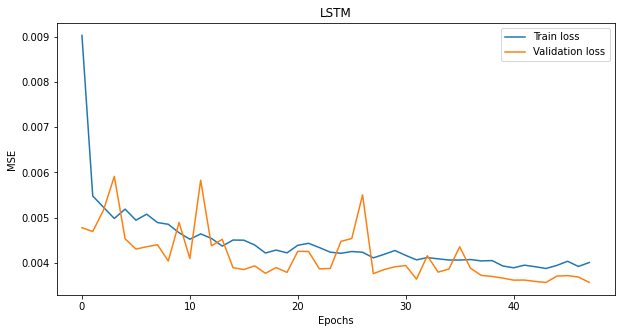

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(history.history['loss'], label='Train loss')
ax3.plot(history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')
plt.show()

In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

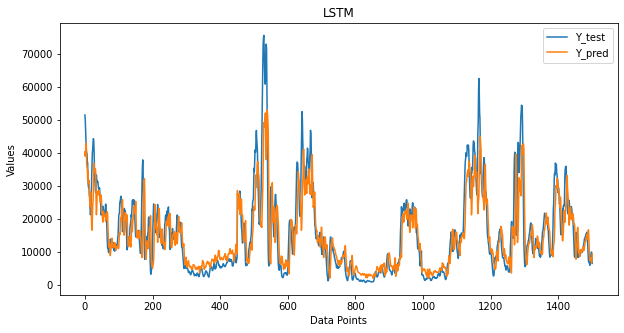

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

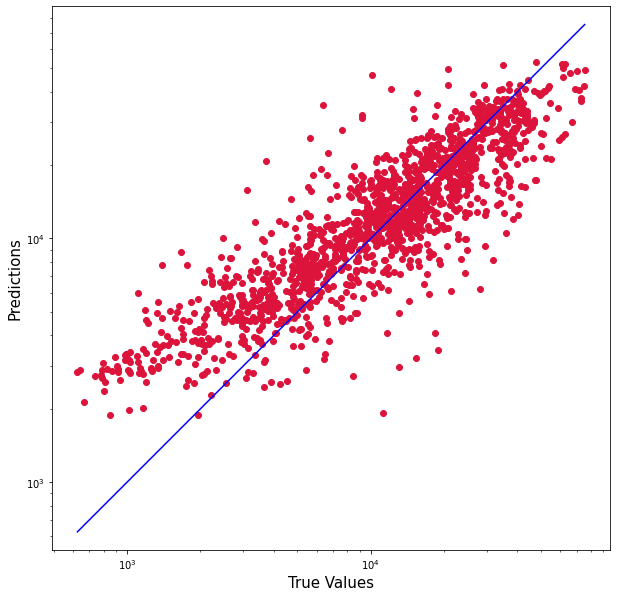

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:

a=Y_test['DL_bitrate'].subtract(Y_pred[5])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

# calculate MAE
error = mae(Y_test, Y_pred)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : 4599.970282957653


# Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=448, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=288, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=256, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 448)               7168      
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 288)               129312    
                                                                 
 dropout_1 (Dropout)         (None, 288)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               73984     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
180/180 [==============================] - 4s 6ms/step - loss: 0.0464 - mean_absolute_error: 0.0463 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 2/500
180/180 [==============================] - 1s 5ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 3/500
180/180 [==============================] - 1s 4ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 4/500
180/180 [==============================] - 1s 5ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350
Epoch 5/500
180/180 [==============================] - 1s 5ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 6/500
180/180 [==============================] - 1s 4ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 7/50

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.05668241996695394
Validation rmse: 0.05962374283944656


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.500000,0.500000,0.500000,0.5,0.5,0.042046,0.062235,0.089621,0.089621,0.077917,0.444444,0.500000,0.500000,0.500000,0.527778
1,0.500000,0.500000,0.500000,0.5,0.5,0.054256,0.042046,0.062235,0.089621,0.089621,0.444444,0.444444,0.500000,0.500000,0.500000
2,0.357143,0.500000,0.500000,0.5,0.5,0.083700,0.054256,0.042046,0.062235,0.089621,0.416667,0.444444,0.444444,0.500000,0.500000
3,0.428571,0.357143,0.500000,0.5,0.5,0.043839,0.083700,0.054256,0.042046,0.062235,0.416667,0.416667,0.444444,0.444444,0.500000
4,0.428571,0.428571,0.357143,0.5,0.5,0.054520,0.043839,0.083700,0.054256,0.042046,0.388889,0.416667,0.416667,0.444444,0.444444


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

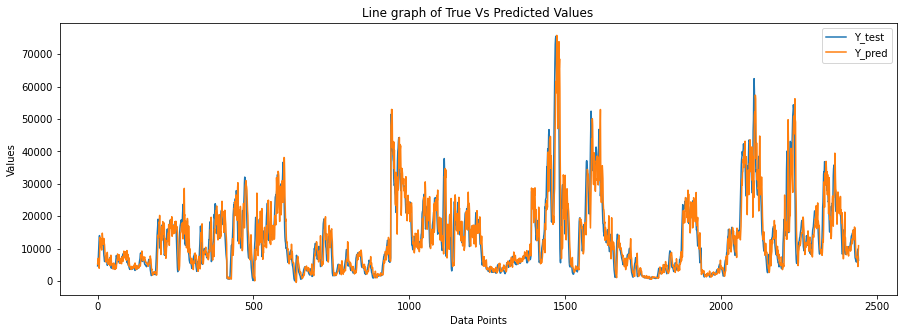

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

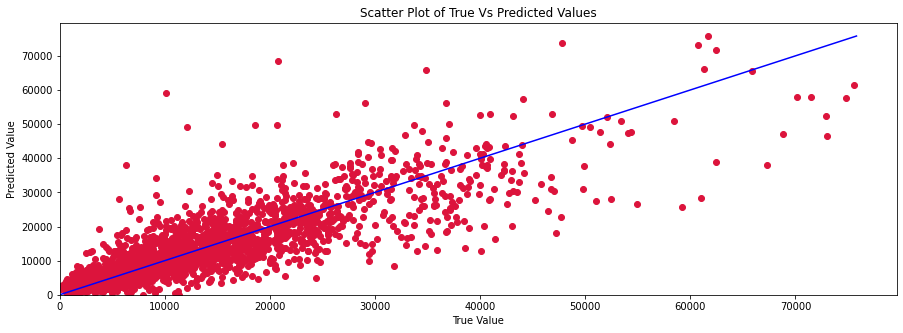

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

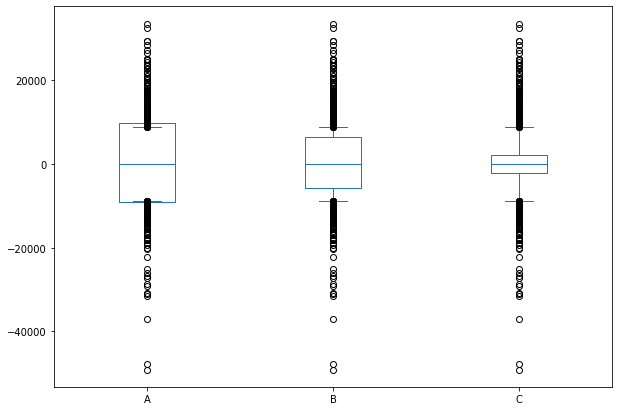

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:

# calculate MAE
error = mae(Y_test, Y_pred)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : tf.Tensor(3812.0546875, shape=(), dtype=float64)


In [ ]:
# Mean Absolute Percentage Error

error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

0.3724924801641656


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.45649666540354805

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.30555395544219843

# Combination of Different Modes of Transportation

In [ ]:
path = r'/content/gdrive/MyDrive/transformed' # use your path
bus_all_files = glob.glob(path + "/bus/*.csv")
car_all_files = glob.glob(path + "/car/*.csv")
pedestrian_all_files = glob.glob(path + "/pedestrian/*.csv")
static_all_files = glob.glob(path + "/static/*.csv")
train_all_files = glob.glob(path + "/train/*.csv")  

In [ ]:
all_files_train=[]
all_files_test=[]

In [ ]:
bus_all_files.sort()
all_files_train = all_files_train + bus_all_files[:-3]
all_files_test = all_files_test + bus_all_files[-3:]

car_all_files.sort()
all_files_train = all_files_train + car_all_files[:-3]
all_files_test = all_files_test + car_all_files[-3:]

pedestrian_all_files.sort()
all_files_train = all_files_train + pedestrian_all_files[:-3]
all_files_test = all_files_test + pedestrian_all_files[-3:]

static_all_files.sort()
all_files_train = all_files_train + static_all_files[:-3]
all_files_test = all_files_test + static_all_files[-3:]

train_all_files.sort()
all_files_train = all_files_train + train_all_files[:-3]
all_files_test = all_files_test + train_all_files[-3:]

In [ ]:
# Train Dataset
li_train = []
for filename in all_files_train:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame_train = pd.concat(li_train, axis=0, ignore_index=True)
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.0,7.0,10.0,10.0,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.0,7.0,7.0,10.0,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.0,8.0,7.0,7.0,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.0,8.0,8.0,7.0,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.0,10.0,8.0,8.0,151,68,0,0,0,2393


In [ ]:
frame_train.shape

(157752, 46)

In [ ]:
# Test Dataset
li_test = []
for filename in all_files_test:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_test.append(df)
frame_test = pd.concat(li_test, axis=0, ignore_index=True)
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,12,11,12,11,11,46905,54253,63379,68557,68557,...,18.0,14.0,14.0,14.0,756,956,972,1026,1026,51399
1,10,12,11,12,11,52184,46905,54253,63379,68557,...,18.0,18.0,14.0,14.0,908,756,956,972,1026,49728
2,12,10,12,11,12,57262,52184,46905,54253,63379,...,16.0,18.0,18.0,14.0,828,908,756,956,972,46853
3,12,12,10,12,11,53862,57262,52184,46905,54253,...,16.0,16.0,18.0,18.0,894,828,908,756,956,43102
4,10,12,12,10,12,57407,53862,57262,52184,46905,...,16.0,16.0,16.0,18.0,1265,894,828,908,756,40899


In [ ]:
frame_test.shape

(15556, 46)

# dealing with NaN Values

## Train Dataset

In [ ]:
frame_train.replace('-', np.NaN, inplace = True)
frame_train.isna().sum().sum()

1312040

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame_train)
frame_train = pd.DataFrame(imputed_dataset,columns = frame_train.columns)
frame_train.isna().sum().sum()

0

In [ ]:
frame_train.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,...,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000
mean,7.641361,7.604101,7.622050,7.609666,7.622525,9724.774957,9727.105653,9729.016608,9731.364503,9733.521521,...,5.801120,5.590722,5.645884,5.740537,168.282424,168.315248,168.343666,168.375545,168.410226,9717.288402
std,2.538428,2.545001,2.541392,2.544898,2.543107,13042.591125,13047.331213,13050.458054,13054.515238,13058.493025,...,6.724060,6.679686,6.690202,6.718909,204.387774,204.453685,204.496334,204.546875,204.604983,12592.534743
min,-0.612255,1.000000,1.000000,1.000000,0.784134,0.000000,0.000000,0.000000,0.000000,0.000000,...,-30.000000,-30.000000,-30.000000,-30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.911007,6.892143,6.958526,6.906773,6.901422,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,...,2.000000,2.000000,2.000000,2.000000,28.000000,28.000000,28.000000,28.000000,28.000000,1417.000000
50%,7.120286,7.004964,7.062224,7.024500,7.068401,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,...,7.228530,6.652735,6.779590,6.975890,95.000000,95.000000,95.000000,95.000000,95.000000,4909.000000
75%,9.000000,9.000000,9.000000,9.000000,9.000000,13141.000000,13141.000000,13152.000000,13152.000000,13152.000000,...,7.776193,7.142767,7.371773,7.885166,242.000000,242.000000,242.000000,242.000000,242.000000,13268.000000
max,15.000000,15.000000,15.000000,15.000000,15.000000,173016.000000,173016.000000,173016.000000,173016.000000,173016.000000,...,33.000000,33.000000,33.000000,33.641380,4178.000000,4178.000000,4178.000000,4178.000000,4178.000000,161878.000000


## Test Dataset

In [ ]:
frame_test.replace('-', np.NaN, inplace = True)
frame_test.isna().sum().sum()

100468

In [ ]:
imputed_dataset = imputer.fit_transform(frame_test)
frame_test = pd.DataFrame(imputed_dataset,columns = frame_test.columns)
frame_test.isna().sum().sum()
frame_test.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,15556.000000,15556.000000,15556.000000,15556.000000,15556.00000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,...,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000
mean,9.215056,9.180175,9.161461,9.130983,9.15669,21794.796542,21794.644639,21799.217344,21806.383968,21813.936745,...,8.089707,8.111215,8.095310,8.232082,349.132168,349.122204,349.173245,349.246207,349.330612,21799.575084
std,2.526213,2.517253,2.512943,2.508262,2.51245,19242.347498,19239.767335,19237.915139,19238.155274,19241.164971,...,7.085187,7.088205,7.082441,7.131404,295.886194,295.811237,295.728444,295.638133,295.647554,18400.133766
min,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-16.000000,-16.000000,-16.000000,-16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.000000,7.000000,7.000000,7.00000,7448.000000,7448.000000,7448.000000,7456.250000,7459.000000,...,3.000000,3.000000,3.000000,3.000000,134.000000,134.000000,134.000000,134.000000,134.000000,8158.500000
50%,9.000000,9.000000,9.000000,9.000000,9.00000,16479.500000,16501.500000,16512.500000,16518.500000,16529.000000,...,8.000000,8.000000,8.000000,8.000000,270.000000,270.000000,271.000000,271.000000,271.000000,16870.500000
75%,11.000000,11.000000,11.000000,11.000000,11.00000,30778.000000,30778.000000,30783.500000,30802.750000,30836.750000,...,12.000000,12.000000,12.000000,12.303084,497.000000,497.000000,497.000000,497.000000,497.000000,30558.000000
max,15.000000,15.000000,15.000000,15.000000,15.00000,108693.000000,108693.000000,108693.000000,108693.000000,108693.000000,...,28.000000,28.000000,28.000000,28.000000,3852.000000,3852.000000,3852.000000,3852.000000,3852.000000,101836.000000


In [ ]:
frame_test.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,15556.000000,15556.000000,15556.000000,15556.000000,15556.00000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,...,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000
mean,9.215056,9.180175,9.161461,9.130983,9.15669,21794.796542,21794.644639,21799.217344,21806.383968,21813.936745,...,8.089707,8.111215,8.095310,8.232082,349.132168,349.122204,349.173245,349.246207,349.330612,21799.575084
std,2.526213,2.517253,2.512943,2.508262,2.51245,19242.347498,19239.767335,19237.915139,19238.155274,19241.164971,...,7.085187,7.088205,7.082441,7.131404,295.886194,295.811237,295.728444,295.638133,295.647554,18400.133766
min,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-16.000000,-16.000000,-16.000000,-16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.000000,7.000000,7.000000,7.00000,7448.000000,7448.000000,7448.000000,7456.250000,7459.000000,...,3.000000,3.000000,3.000000,3.000000,134.000000,134.000000,134.000000,134.000000,134.000000,8158.500000
50%,9.000000,9.000000,9.000000,9.000000,9.00000,16479.500000,16501.500000,16512.500000,16518.500000,16529.000000,...,8.000000,8.000000,8.000000,8.000000,270.000000,270.000000,271.000000,271.000000,271.000000,16870.500000
75%,11.000000,11.000000,11.000000,11.000000,11.00000,30778.000000,30778.000000,30783.500000,30802.750000,30836.750000,...,12.000000,12.000000,12.000000,12.303084,497.000000,497.000000,497.000000,497.000000,497.000000,30558.000000
max,15.000000,15.000000,15.000000,15.000000,15.00000,108693.000000,108693.000000,108693.000000,108693.000000,108693.000000,...,28.000000,28.000000,28.000000,28.000000,3852.000000,3852.000000,3852.000000,3852.000000,3852.000000,101836.000000


# MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:15], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (110426, 15)
Validation set shape (47326, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
83480,0.489748,0.424739,0.428401,0.429171,0.440638,0.010092,0.006462,0.002196,0.001936,0.002196,0.618416,0.591880,0.584939,0.586633,0.584557
116859,0.615687,0.571429,0.428571,0.642857,0.577936,0.010404,0.008722,0.005427,0.005167,0.009433,0.571429,0.587302,0.587302,0.587302,0.581383
81722,0.487582,0.357143,0.357143,0.357143,0.507592,0.001809,0.001352,0.001422,0.001873,0.000387,0.460317,0.460317,0.460317,0.507937,0.502818
111880,0.615687,0.571429,0.571429,0.571429,0.577936,0.040008,0.035355,0.041366,0.041112,0.043175,0.619048,0.603175,0.603175,0.619048,0.612809
88395,0.423530,0.357143,0.428571,0.285714,0.296561,0.017900,0.034130,0.042984,0.024495,0.088425,0.476190,0.492063,0.492063,0.428571,0.424252


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (110426, 15, 1)
Validation set shape (47326, 15, 1)


# Stacked LSTM

In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=256, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=384, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=128, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 256)               4096      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 384)               98688     
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               49280     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
3451/3451 [==============================] - 16s 4ms/step - loss: 0.0160 - mean_absolute_error: 0.0160 - val_loss: 0.0152 - val_mean_absolute_error: 0.0152
Epoch 2/500
3451/3451 [==============================] - 12s 4ms/step - loss: 0.0152 - mean_absolute_error: 0.0152 - val_loss: 0.0154 - val_mean_absolute_error: 0.0154
Epoch 3/500
3451/3451 [==============================] - 12s 4ms/step - loss: 0.0151 - mean_absolute_error: 0.0151 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146
Epoch 4/500
3451/3451 [==============================] - 12s 4ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146
Epoch 5/500
3451/3451 [==============================] - 12s 4ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0151 - val_mean_absolute_error: 0.0151
Epoch 6/500
3451/3451 [==============================] - 12s 4ms/step - loss: 0.0148 - mean_absolute_error: 0.0148 - val_loss: 0.0152 - val_mean_absolute_error:

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.027892394672983947
Validation rmse: 0.027638418856573265


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.785714,0.714286,0.785714,0.714286,0.714286,0.431537,0.499140,0.583101,0.630740,0.630740,0.772727,0.772727,0.681818,0.681818,0.681818
1,0.642857,0.785714,0.714286,0.785714,0.714286,0.480105,0.431537,0.499140,0.583101,0.630740,0.727273,0.772727,0.772727,0.681818,0.681818
2,0.785714,0.642857,0.785714,0.714286,0.785714,0.526823,0.480105,0.431537,0.499140,0.583101,0.727273,0.727273,0.772727,0.772727,0.681818
3,0.785714,0.785714,0.642857,0.785714,0.714286,0.495542,0.526823,0.480105,0.431537,0.499140,0.727273,0.727273,0.727273,0.772727,0.772727
4,0.642857,0.785714,0.785714,0.642857,0.785714,0.528157,0.495542,0.526823,0.480105,0.431537,0.727273,0.727273,0.727273,0.727273,0.772727


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

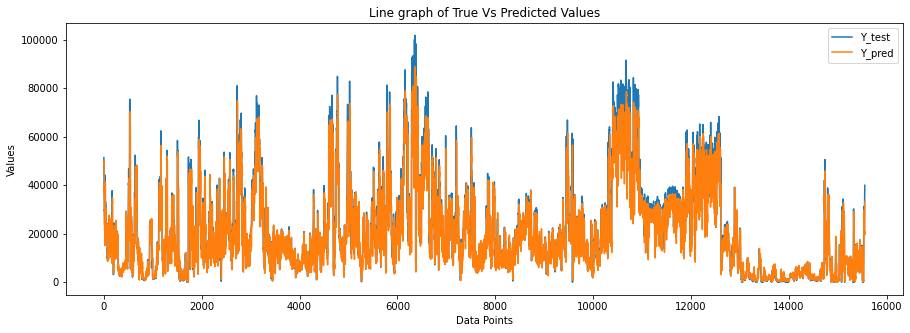

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

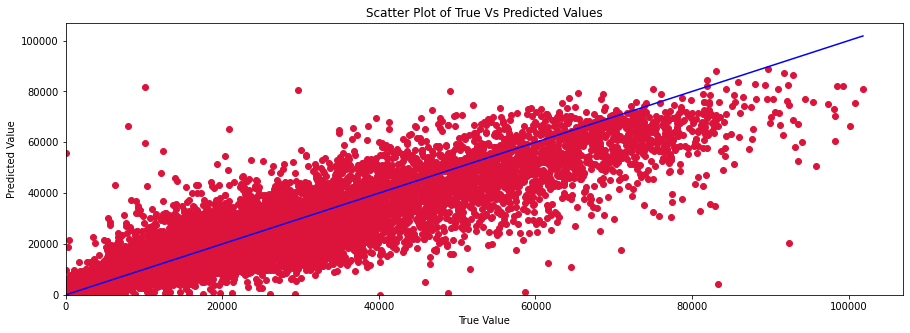

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

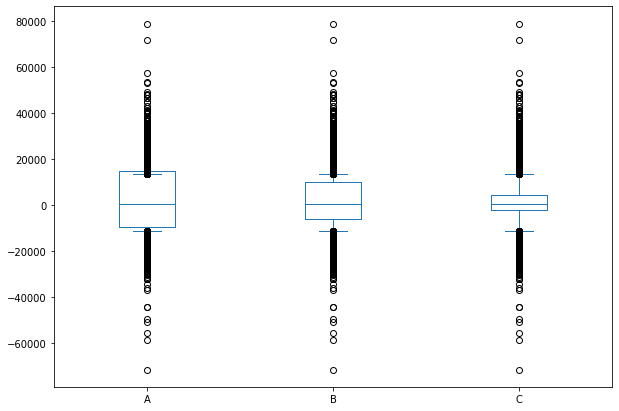

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:

# calculate MAE
error = mae(Y_test, Y_pred)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : tf.Tensor(5017.69677734375, shape=(), dtype=float64)


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)
#0.3517153999832994

In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.3781740125597771

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.21557142758955594